# Application: Galaxy Classification with Keras

Now we'll try to do the galaxy classification with Keras.  This will allow us to explore more features
in the network.

In particular we'll use a [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

We'll need the `Galaxy` class we defined earlier.

In [2]:
galaxy_types = {0: "disturbed galaxies",
                1: "merging galaxies",
                2: "round smooth galaxies",
                3: "in-between round smooth galaxies",
                4: "cigar shaped smooth galaxies",
                5: "barred spiral galaxies",
                6: "unbarred tight spiral galaxies",
                7: "unbarred loose spiral galaxies",
                8: "edge-on galaxies without bulge",
                9: "edge-on galaxies with bulge"}

In [3]:
class Galaxy:
    def __init__(self, data, answer, *, index=-1):
        self.data = np.array(data, dtype=np.float32) / 255.0
        self.answer = answer

        self.index = index

    def plot(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        ax.imshow(self.data, interpolation="nearest")
        ax.text(0.025, 0.95, f"answer: {self.answer}",
                color="white", transform=ax.transAxes)

    def validate(self, prediction):
        """check if a categorical prediction matches the answer"""
        return np.argmax(prediction) == self.answer

## A data manager class

We'll create a class to manage access to the data.  This is similar to the version in our "from scratch" implementation,
except we do the batching in the generator.
This will do the following:

* open the file and store the handles to access the data
* partition the data into test and training sets
* allow for transformations (rotation, flipping)
* provide a means to shuffle the data
* provide a [generator](https://wiki.python.org/moin/Generators) to get the next *batch* of training data
* allow us to coarsen the images to a reduced resolution to make the training easier.

```{tip}
We will read all of the data once, which will take about 3.5 GB of memory.  It is kept
as a `uint8` until needed.
```

In [4]:
from keras.utils import to_categorical

In [5]:
class DataManager:
    def __init__(self, partition=0.8,
                 batch_size=32,
                 n_transforms=1,
                 datafile="Galaxy10_DECals.h5",
                 coarsen=1):
        """manage access to the data

        partition: fraction that should be training
        datafile: name of the hdf5 file with the data
        coarsen: reduce the number of pixels by this factor
        """

        self.ds = h5py.File(datafile)
        self.ans = np.array(self.ds["ans"])
        self.images = np.array(self.ds["images"])

        self.coarsen = coarsen
        self.n_transforms = n_transforms
        
        self.batch_size = batch_size
        
        N = len(self.ans)

        # create a set of indices for the galaxies and randomize
        self.indices = np.arange(N, dtype=np.uint32)
        self.rng = np.random.default_rng()
        self.rng.shuffle(self.indices)

        # partition into training and test sets
        # these indices will always refer to the index in the original
        # unsplit dataset
        n_cut = int(partition * N)

        # we want this to be a multiple of the batch size
        n_cut -= n_cut % self.batch_size

        self.training_indices = self.indices[0:n_cut]
        self.test_indices = self.indices[n_cut:N]

        self.n_training = len(self.training_indices)
        self.n_test = len(self.test_indices)

        # number of batches for the training
        self.n_batches = n_cut // self.batch_size
        self.n_batches *= (n_transforms + 1)
        
        # shape information
        self.input_shape = self._get_galaxy(0).data.shape
    
    def _get_galaxy(self, index):
        """return a numpy array containing a single galaxy image, coarsened
        if necessary by averaging"""
        _tmp = self.images[index, :, :, :]
        if self.coarsen > 1:
            _tmp = np.mean(_tmp.reshape(_tmp.shape[0]//self.coarsen, self.coarsen,
                                        _tmp.shape[1]//self.coarsen, self.coarsen,
                                        _tmp.shape[2]), axis=(1, 3))
        return _tmp

    def training_images(self):
        self.reset_training()
        for idx in self.training_indices:
            yield Galaxy(self._get_galaxy(idx), self.ans[idx], index=idx)

    def batched_training_generator(self):
        while True:
            self.reset_training()
            batch_x = []
            batch_y = []
            for idx in self.training_indices:
                g = Galaxy(self._get_galaxy(idx), self.ans[idx], index=idx)
                batch_x.append(g.data)
                batch_y.append(to_categorical(g.answer, 10))

                if self.n_transforms > 0:
                    # rotation
                    batch_x.append(np.rot90(g.data, axes=(0, 1)))
                    batch_y.append(to_categorical(g.answer, 10))

                if self.n_transforms > 1:
                    # flipping first axis
                    batch_x.append(g.data[::-1, :, :])
                    batch_y.append(to_categorical(g.answer, 10))

                if self.n_transforms > 2:
                    # flipping second axis
                    batch_x.append(g.data[:, ::-1, :])
                    batch_y.append(to_categorical(g.answer, 10))

                if len(batch_x) == self.batch_size:
                    yield (np.array(batch_x), np.array(batch_y))
                    batch_x = []
                    batch_y = []

    def reset_training(self):
        """prepare for the next epoch: shuffle the training data and
        reset the index to point to the start"""
        self.rng.shuffle(self.training_indices)

    def testing_images(self):
        for idx in self.test_indices:
            yield Galaxy(self._get_galaxy(idx), self.ans[idx], index=idx)

````{tip}
The `training_images()` and `testing_images()` are generators (like `range()`), so we can iterate like:

```python
d = DataManager()
for g in d.training_images():
    # do stuff with g
```

and `g` is only converted to 32-bit float as needed.
````

Here we create a `DataManager` that will coarsen the images by a factor of 4 (so they will be 64x64 pixels with 3 colors).
We also need to specify the batch size.

In [6]:
d = DataManager(coarsen=2, batch_size=128)

In [7]:
for n, (x, y) in enumerate(d.batched_training_generator()):
    print(x.shape)
    break

(128, 128, 128, 3)


In [8]:
d.input_shape

(128, 128, 3)

we can see how many images there are in the training and test sets

In [9]:
d.n_training, d.n_test

(14080, 3656)

In [10]:
d.n_batches

220

We can then get loop over training galaxies and look at them (we'll break after 5):

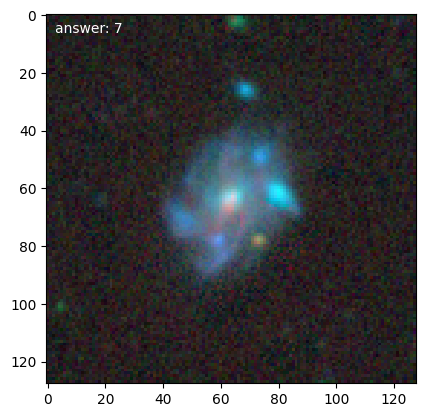

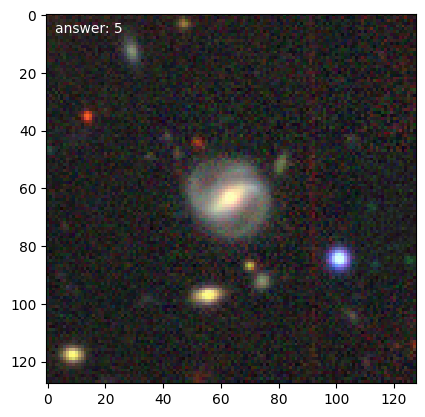

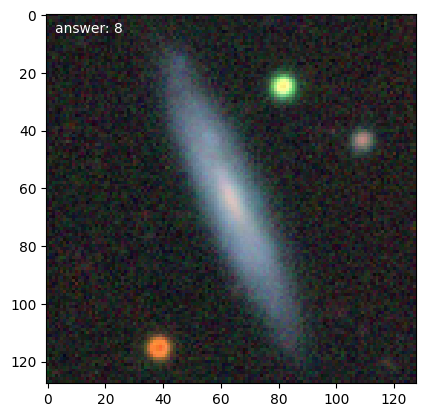

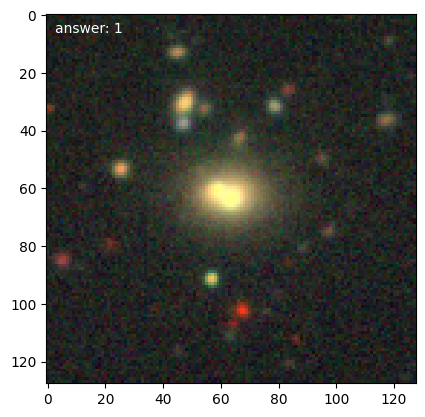

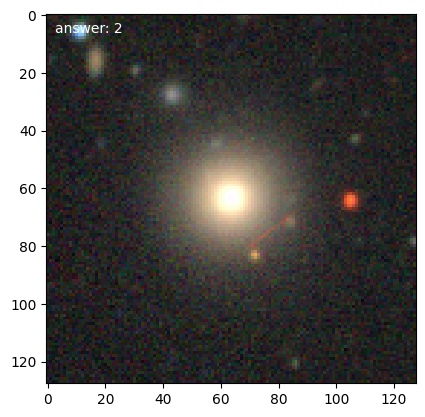

In [11]:
for n, g in enumerate(d.training_images()):
    g.plot()
    if n == 4:
        break

```{note}
Each time we access the generator it randomizes the galaxies in the training set.
```

## Implementing our neural network

We'll use just a single hidden layer.  If we use more hidden layers, then there are so many parameters that we will need to do a lot of training (epochs).

```{tip}
Our `DataManager` will tell us the size of the input layer, the number of batches, the batch size, etc.
```

In [12]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten

In [13]:
model = Sequential()
model.add(Input(shape=d.input_shape))

model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(10, activation="softmax"))

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │       184,330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 471,338 (1.80 MB)

 Trainable params: 471,338 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

We'll use a different optimizer now, the `Adam` optimizer.  This is supposed to be one of the best that Keras provides.

In [15]:
from keras.optimizers import Adam

rms = Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=rms, metrics=['accuracy'])

The keras `fit()` method can work with a generator directly, so we just pass in the generator.

In [16]:
model.fit(d.batched_training_generator(),
          batch_size=d.batch_size,
          steps_per_epoch=d.n_batches,
          epochs=25)

Epoch 1/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.2580 - loss: 1.9696
Epoch 2/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.5889 - loss: 1.1920
Epoch 3/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.7057 - loss: 0.8792
Epoch 4/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.7686 - loss: 0.6837
Epoch 5/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.8089 - loss: 0.5588
Epoch 6/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.8374 - loss: 0.4862
Epoch 7/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.8750 - loss: 0.3714
Epoch 8/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.9020 - loss: 0.2928
Epoch 9/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.9249 - loss: 0.2189
Epoch 10/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.9411 - loss: 0.1760
Epoch 11/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.9582 - loss: 0.1278
Epoch 12/25
220/220 ━━━━━━━━━━━━━━━━━━━━ 

## Assessing 

Now try the test set that the training did not see

In [17]:
n_correct = 0
for g in d.testing_images():
    res = model.predict(np.expand_dims(g.data, axis=0), verbose=0)
    if np.argmax(res) == g.answer:
        n_correct += 1
print(f"fraction correct = {n_correct / d.n_test}")

fraction correct = 0.7097921225382933


We see that we are getting about 70% of the galaxies we didn't train on correct.